In [1]:
import copy
from functools import partial
import gc
from tensorflow import keras
from matplotlib import pyplot as plt
import numpy as np
from uncertainty_testbed.generators.data_generator_explicit import AnalyticBinaryClassGenerator
from uncertainty_testbed.utilities.functions import map_to_constant
from uncertainty_testbed.uncertainty_models.mc_dropout import MCDropoutLayer, MCDropoutKerasClassification

2022-05-07 20:45:51.964404: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-07 20:45:51.964444: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# generate some data
s = partial(map_to_constant, c=0.1)
eg = AnalyticBinaryClassGenerator(seed=42, num_inputs=10, name="gauss", threshold=0.5,
                                  noise_distribution="gauss", noise_scale=s)
x, y = eg.generate_labeled(120096)
x = x.astype("float32")
y = y.astype("uint8")
x_train, y_train = x[:33280, :], y[:33280]
x_val, y_val = x[100096:, :], y[100096:]

In [3]:
def opt_name(optimizer):
    return str(optimizer).split("object")[0].split(".")[-1].strip().lower()

optimizer_lookup = {
    opt_name(opt): opt for opt in  
    [keras.optimizers.Nadam(learning_rate=3e-5), 
     keras.optimizers.SGD(learning_rate=5e-3), 
     keras.optimizers.RMSprop(learning_rate=5e-3),
     keras.optimizers.Adam(learning_rate=3e-3),
     keras.optimizers.Adadelta(learning_rate=1e-1),
     keras.optimizers.Adamax(learning_rate=7e-3)]
}

scan_schedule = [
    {
        "optimizer": keras.optimizers.Nadam(learning_rate=3e-5),
        "learning_rate": 3e-5,
        "batch": 256,
        "epoch": 3*28
    },
    {
        "optimizer": keras.optimizers.SGD(learning_rate=5e-3),
        "learning_rate": 5e-3,
        "batch": 256,
        "epoch": 3*59
    },
    {
        "optimizer": keras.optimizers.SGD(learning_rate=1e-2),
        "learning_rate" :1e-2,
        "batch": 8,
        "epoch": 3*1
    },
    {
        "optimizer": keras.optimizers.RMSprop(learning_rate=5e-3),
        "learning_rate": 5e-3,
        "batch": 8,
        "epoch": 3*1# 0.1781
    },
    {
        "optimizer": keras.optimizers.Adam(learning_rate=3e-3),
        "learning_rate": 3e-3,
        "batch": 8,
        "epoch": 3*1# 0.2076
    },
    {
        "optimizer": keras.optimizers.Adadelta(learning_rate=1e-1),
        "learning_rate": 1e-1,
        "batch": 8,
        "epoch": 3*2# 0.2354
    },
    {
        "optimizer": keras.optimizers.Adamax(learning_rate=7e-3),
        "learning_rate": 7e-3,
        "batch": 8,
        "epoch": 3*1# 0.2249
    },
    {
        "optimizer": keras.optimizers.Nadam(learning_rate=7e-3),
        "learning_rate": 7e-3,
        "batch": 8,
        "epoch": 3*4# 0.1905
    }
]

In [4]:
scan_results = []
champion_params = None
champion_loss = np.inf
for params in scan_schedule:
    lr = params["learning_rate"]
    for learning_rate in [0.8*lr, lr, 1.2*lr]:
        optimizer = params["optimizer"]
        optimizer.learning_rate.assign(learning_rate)
        num_epochs = int(1.4*params["epoch"] + 2)
        batch_size = int(params["batch"])
        model = keras.Sequential()
        model.add(keras.layers.Dense(30, activation="relu"))
        model.add(keras.layers.Dropout(0.25))
        model.add(keras.layers.Dense(30, activation="relu"))
        model.add(keras.layers.Dropout(0.25))
        model.add(keras.layers.Dense(30, activation="relu"))
        model.add(keras.layers.Dropout(0.25))
        model.add(keras.layers.Dense(1, activation="sigmoid"))
        model.compile(
            optimizer=optimizer,
            loss="binary_crossentropy",
            metrics=["accuracy", "AUC"]
        )
        history = model.fit(
            x_train,
            y_train,
            epochs=num_epochs,
            batch_size=batch_size,
            validation_data=(x_val, y_val),
        )
        
        history_dict = history.history
        val_loss = history_dict["val_loss"]
        val_auc = history_dict["val_auc"]
        val_accuracy = history_dict["val_accuracy"]
        epochs = range(1, len(val_loss)+1)
        
        best_loss = {"loss": val_loss[np.argmin(val_loss)], "epoch": epochs[np.argmin(val_loss)]}
        best_auc = {"auc": val_auc[np.argmax(val_auc)], "epoch": epochs[np.argmax(val_auc)]}
        best_accuracy = {"accuracy": val_accuracy[np.argmax(val_accuracy)], "epoch": epochs[np.argmax(val_accuracy)]}
        
        ps = {k: copy.deepcopy(v) for k, v in params.items() if k not in ["optimizer", "model"]}
        ps["optimizer"] = opt_name(optimizer)
        ps["learning_rate"] = copy.deepcopy(learning_rate)
        ps["best_loss"] = best_loss
        ps["best_auc"] = best_auc
        ps["best_accuracy"] = best_accuracy
        print(ps)
        scan_results.append(ps)
        
        if best_loss["loss"] < champion_loss:
            champion_loss = best_loss["loss"]
            champion_params = {k: copy.deepcopy(v) for k, v in ps.items()}
            champion_params["model"] = keras.models.clone_model(model)
        

model = keras.models.clone_model(champion_params["model"])

Epoch 1/119


2022-05-07 20:45:55.077583: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-07 20:45:55.077633: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-07 20:45:55.077659: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (xps): /proc/driver/nvidia/version does not exist
2022-05-07 20:45:55.078731: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


130/130 [==============================] - 3s 10ms/step - loss: 0.7107 - accuracy: 0.5202 - auc: 0.5292 - val_loss: 0.6838 - val_accuracy: 0.5612 - val_auc: 0.5963
Epoch 2/119
130/130 [==============================] - 1s 5ms/step - loss: 0.6954 - accuracy: 0.5461 - auc: 0.5643 - val_loss: 0.6719 - val_accuracy: 0.6097 - val_auc: 0.6529
Epoch 3/119
130/130 [==============================] - 1s 4ms/step - loss: 0.6828 - accuracy: 0.5669 - auc: 0.5956 - val_loss: 0.6600 - val_accuracy: 0.6520 - val_auc: 0.7061
Epoch 4/119
130/130 [==============================] - 1s 5ms/step - loss: 0.6735 - accuracy: 0.5813 - auc: 0.6200 - val_loss: 0.6477 - val_accuracy: 0.6865 - val_auc: 0.7520
Epoch 5/119
130/130 [==============================] - 1s 5ms/step - loss: 0.6618 - accuracy: 0.6048 - auc: 0.6488 - val_loss: 0.6348 - val_accuracy: 0.7193 - val_auc: 0.7918
Epoch 6/119
130/130 [==============================] - 1s 5ms/step - loss: 0.6514 - accuracy: 0.6244 - auc: 0.6730 - val_loss: 0.6210 - 

Epoch 48/119
130/130 [==============================] - 1s 4ms/step - loss: 0.2200 - accuracy: 0.9090 - auc: 0.9706 - val_loss: 0.1214 - val_accuracy: 0.9598 - val_auc: 0.9948
Epoch 49/119
130/130 [==============================] - 1s 6ms/step - loss: 0.2131 - accuracy: 0.9105 - auc: 0.9726 - val_loss: 0.1189 - val_accuracy: 0.9604 - val_auc: 0.9950
Epoch 50/119
130/130 [==============================] - 1s 5ms/step - loss: 0.2118 - accuracy: 0.9121 - auc: 0.9728 - val_loss: 0.1165 - val_accuracy: 0.9613 - val_auc: 0.9952
Epoch 51/119
130/130 [==============================] - 1s 4ms/step - loss: 0.2059 - accuracy: 0.9148 - auc: 0.9743 - val_loss: 0.1142 - val_accuracy: 0.9620 - val_auc: 0.9953
Epoch 52/119
130/130 [==============================] - 1s 6ms/step - loss: 0.2063 - accuracy: 0.9142 - auc: 0.9742 - val_loss: 0.1122 - val_accuracy: 0.9622 - val_auc: 0.9955
Epoch 53/119
130/130 [==============================] - 1s 4ms/step - loss: 0.2042 - accuracy: 0.9151 - auc: 0.9747 - va

130/130 [==============================] - 1s 6ms/step - loss: 0.1374 - accuracy: 0.9431 - auc: 0.9885 - val_loss: 0.0694 - val_accuracy: 0.9764 - val_auc: 0.9981
Epoch 95/119
130/130 [==============================] - 1s 4ms/step - loss: 0.1315 - accuracy: 0.9450 - auc: 0.9894 - val_loss: 0.0688 - val_accuracy: 0.9765 - val_auc: 0.9981
Epoch 96/119
130/130 [==============================] - 1s 6ms/step - loss: 0.1325 - accuracy: 0.9460 - auc: 0.9892 - val_loss: 0.0683 - val_accuracy: 0.9768 - val_auc: 0.9982
Epoch 97/119
130/130 [==============================] - 1s 5ms/step - loss: 0.1312 - accuracy: 0.9465 - auc: 0.9895 - val_loss: 0.0677 - val_accuracy: 0.9767 - val_auc: 0.9982
Epoch 98/119
130/130 [==============================] - 1s 6ms/step - loss: 0.1323 - accuracy: 0.9450 - auc: 0.9892 - val_loss: 0.0672 - val_accuracy: 0.9771 - val_auc: 0.9982
Epoch 99/119
130/130 [==============================] - 1s 6ms/step - loss: 0.1322 - accuracy: 0.9451 - auc: 0.9893 - val_loss: 0.066

130/130 [==============================] - 1s 4ms/step - loss: 0.2644 - accuracy: 0.8894 - auc: 0.9585 - val_loss: 0.1569 - val_accuracy: 0.9517 - val_auc: 0.9927
Epoch 21/119
130/130 [==============================] - 1s 4ms/step - loss: 0.2579 - accuracy: 0.8917 - auc: 0.9607 - val_loss: 0.1507 - val_accuracy: 0.9531 - val_auc: 0.9932
Epoch 22/119
130/130 [==============================] - 1s 4ms/step - loss: 0.2520 - accuracy: 0.8949 - auc: 0.9622 - val_loss: 0.1449 - val_accuracy: 0.9544 - val_auc: 0.9936
Epoch 23/119
130/130 [==============================] - 1s 4ms/step - loss: 0.2454 - accuracy: 0.8969 - auc: 0.9640 - val_loss: 0.1397 - val_accuracy: 0.9557 - val_auc: 0.9940
Epoch 24/119
130/130 [==============================] - 1s 4ms/step - loss: 0.2430 - accuracy: 0.8972 - auc: 0.9646 - val_loss: 0.1349 - val_accuracy: 0.9574 - val_auc: 0.9944
Epoch 25/119
130/130 [==============================] - 1s 4ms/step - loss: 0.2358 - accuracy: 0.9008 - auc: 0.9665 - val_loss: 0.130

130/130 [==============================] - 1s 4ms/step - loss: 0.1345 - accuracy: 0.9446 - auc: 0.9889 - val_loss: 0.0647 - val_accuracy: 0.9783 - val_auc: 0.9985
Epoch 67/119
130/130 [==============================] - 1s 4ms/step - loss: 0.1330 - accuracy: 0.9444 - auc: 0.9892 - val_loss: 0.0639 - val_accuracy: 0.9786 - val_auc: 0.9986
Epoch 68/119
130/130 [==============================] - 1s 4ms/step - loss: 0.1297 - accuracy: 0.9462 - auc: 0.9897 - val_loss: 0.0633 - val_accuracy: 0.9788 - val_auc: 0.9986
Epoch 69/119
130/130 [==============================] - 1s 4ms/step - loss: 0.1315 - accuracy: 0.9453 - auc: 0.9894 - val_loss: 0.0627 - val_accuracy: 0.9790 - val_auc: 0.9986
Epoch 70/119
130/130 [==============================] - 1s 4ms/step - loss: 0.1296 - accuracy: 0.9466 - auc: 0.9897 - val_loss: 0.0622 - val_accuracy: 0.9791 - val_auc: 0.9986
Epoch 71/119
130/130 [==============================] - 1s 4ms/step - loss: 0.1266 - accuracy: 0.9479 - auc: 0.9902 - val_loss: 0.061

130/130 [==============================] - 1s 4ms/step - loss: 0.0893 - accuracy: 0.9642 - auc: 0.9950 - val_loss: 0.0466 - val_accuracy: 0.9825 - val_auc: 0.9990
Epoch 113/119
130/130 [==============================] - 1s 4ms/step - loss: 0.0868 - accuracy: 0.9642 - auc: 0.9954 - val_loss: 0.0462 - val_accuracy: 0.9827 - val_auc: 0.9990
Epoch 114/119
130/130 [==============================] - 1s 4ms/step - loss: 0.0880 - accuracy: 0.9639 - auc: 0.9952 - val_loss: 0.0461 - val_accuracy: 0.9826 - val_auc: 0.9990
Epoch 115/119
130/130 [==============================] - 1s 4ms/step - loss: 0.0867 - accuracy: 0.9654 - auc: 0.9953 - val_loss: 0.0459 - val_accuracy: 0.9829 - val_auc: 0.9990
Epoch 116/119
130/130 [==============================] - 0s 4ms/step - loss: 0.0856 - accuracy: 0.9653 - auc: 0.9955 - val_loss: 0.0457 - val_accuracy: 0.9829 - val_auc: 0.9990
Epoch 117/119
130/130 [==============================] - 1s 4ms/step - loss: 0.0851 - accuracy: 0.9649 - auc: 0.9956 - val_loss: 

130/130 [==============================] - 1s 4ms/step - loss: 0.1633 - accuracy: 0.9317 - auc: 0.9838 - val_loss: 0.0838 - val_accuracy: 0.9719 - val_auc: 0.9974
Epoch 39/119
130/130 [==============================] - 1s 4ms/step - loss: 0.1597 - accuracy: 0.9341 - auc: 0.9845 - val_loss: 0.0822 - val_accuracy: 0.9722 - val_auc: 0.9975
Epoch 40/119
130/130 [==============================] - 1s 4ms/step - loss: 0.1585 - accuracy: 0.9348 - auc: 0.9847 - val_loss: 0.0807 - val_accuracy: 0.9725 - val_auc: 0.9976
Epoch 41/119
130/130 [==============================] - 1s 4ms/step - loss: 0.1540 - accuracy: 0.9366 - auc: 0.9856 - val_loss: 0.0791 - val_accuracy: 0.9729 - val_auc: 0.9977
Epoch 42/119
130/130 [==============================] - 1s 4ms/step - loss: 0.1507 - accuracy: 0.9373 - auc: 0.9861 - val_loss: 0.0777 - val_accuracy: 0.9734 - val_auc: 0.9977
Epoch 43/119
130/130 [==============================] - 0s 4ms/step - loss: 0.1481 - accuracy: 0.9381 - auc: 0.9867 - val_loss: 0.076

130/130 [==============================] - 1s 4ms/step - loss: 0.0915 - accuracy: 0.9630 - auc: 0.9949 - val_loss: 0.0490 - val_accuracy: 0.9807 - val_auc: 0.9989
Epoch 85/119
130/130 [==============================] - 1s 4ms/step - loss: 0.0913 - accuracy: 0.9626 - auc: 0.9949 - val_loss: 0.0486 - val_accuracy: 0.9809 - val_auc: 0.9989
Epoch 86/119
130/130 [==============================] - 1s 4ms/step - loss: 0.0915 - accuracy: 0.9621 - auc: 0.9949 - val_loss: 0.0481 - val_accuracy: 0.9814 - val_auc: 0.9990
Epoch 87/119
130/130 [==============================] - 1s 4ms/step - loss: 0.0888 - accuracy: 0.9635 - auc: 0.9951 - val_loss: 0.0478 - val_accuracy: 0.9813 - val_auc: 0.9990
Epoch 88/119
130/130 [==============================] - 1s 4ms/step - loss: 0.0887 - accuracy: 0.9637 - auc: 0.9952 - val_loss: 0.0475 - val_accuracy: 0.9811 - val_auc: 0.9990
Epoch 89/119
130/130 [==============================] - 1s 4ms/step - loss: 0.0903 - accuracy: 0.9627 - auc: 0.9950 - val_loss: 0.047

130/130 [==============================] - 0s 3ms/step - loss: 0.5631 - accuracy: 0.7242 - auc: 0.7998 - val_loss: 0.5063 - val_accuracy: 0.8126 - val_auc: 0.8961
Epoch 11/249
130/130 [==============================] - 0s 3ms/step - loss: 0.5418 - accuracy: 0.7428 - auc: 0.8203 - val_loss: 0.4787 - val_accuracy: 0.8253 - val_auc: 0.9101
Epoch 12/249
130/130 [==============================] - 0s 4ms/step - loss: 0.5174 - accuracy: 0.7621 - auc: 0.8411 - val_loss: 0.4494 - val_accuracy: 0.8385 - val_auc: 0.9231
Epoch 13/249
130/130 [==============================] - 0s 4ms/step - loss: 0.4961 - accuracy: 0.7747 - auc: 0.8557 - val_loss: 0.4195 - val_accuracy: 0.8528 - val_auc: 0.9354
Epoch 14/249
130/130 [==============================] - 0s 4ms/step - loss: 0.4713 - accuracy: 0.7904 - auc: 0.8722 - val_loss: 0.3886 - val_accuracy: 0.8674 - val_auc: 0.9464
Epoch 15/249
130/130 [==============================] - 0s 4ms/step - loss: 0.4476 - accuracy: 0.8046 - auc: 0.8857 - val_loss: 0.357

130/130 [==============================] - 1s 4ms/step - loss: 0.1196 - accuracy: 0.9545 - auc: 0.9914 - val_loss: 0.0522 - val_accuracy: 0.9816 - val_auc: 0.9989
Epoch 57/249
130/130 [==============================] - 1s 5ms/step - loss: 0.1155 - accuracy: 0.9566 - auc: 0.9920 - val_loss: 0.0516 - val_accuracy: 0.9818 - val_auc: 0.9990
Epoch 58/249
130/130 [==============================] - 0s 4ms/step - loss: 0.1154 - accuracy: 0.9550 - auc: 0.9920 - val_loss: 0.0512 - val_accuracy: 0.9819 - val_auc: 0.9990
Epoch 59/249
130/130 [==============================] - 1s 4ms/step - loss: 0.1139 - accuracy: 0.9563 - auc: 0.9922 - val_loss: 0.0506 - val_accuracy: 0.9818 - val_auc: 0.9990
Epoch 60/249
130/130 [==============================] - 1s 4ms/step - loss: 0.1120 - accuracy: 0.9575 - auc: 0.9924 - val_loss: 0.0501 - val_accuracy: 0.9819 - val_auc: 0.9990
Epoch 61/249
130/130 [==============================] - 0s 4ms/step - loss: 0.1112 - accuracy: 0.9572 - auc: 0.9926 - val_loss: 0.049

130/130 [==============================] - 0s 4ms/step - loss: 0.0808 - accuracy: 0.9709 - auc: 0.9957 - val_loss: 0.0421 - val_accuracy: 0.9832 - val_auc: 0.9991
Epoch 103/249
130/130 [==============================] - 0s 4ms/step - loss: 0.0786 - accuracy: 0.9709 - auc: 0.9961 - val_loss: 0.0420 - val_accuracy: 0.9830 - val_auc: 0.9991
Epoch 104/249
130/130 [==============================] - 0s 4ms/step - loss: 0.0800 - accuracy: 0.9695 - auc: 0.9960 - val_loss: 0.0419 - val_accuracy: 0.9831 - val_auc: 0.9991
Epoch 105/249
130/130 [==============================] - 0s 4ms/step - loss: 0.0783 - accuracy: 0.9720 - auc: 0.9962 - val_loss: 0.0418 - val_accuracy: 0.9834 - val_auc: 0.9991
Epoch 106/249
130/130 [==============================] - 0s 4ms/step - loss: 0.0787 - accuracy: 0.9701 - auc: 0.9961 - val_loss: 0.0417 - val_accuracy: 0.9832 - val_auc: 0.9991
Epoch 107/249
130/130 [==============================] - 0s 4ms/step - loss: 0.0782 - accuracy: 0.9718 - auc: 0.9962 - val_loss: 

130/130 [==============================] - 0s 4ms/step - loss: 0.0680 - accuracy: 0.9753 - auc: 0.9970 - val_loss: 0.0408 - val_accuracy: 0.9830 - val_auc: 0.9991
Epoch 149/249
130/130 [==============================] - 0s 4ms/step - loss: 0.0669 - accuracy: 0.9753 - auc: 0.9970 - val_loss: 0.0408 - val_accuracy: 0.9832 - val_auc: 0.9991
Epoch 150/249
130/130 [==============================] - 0s 4ms/step - loss: 0.0675 - accuracy: 0.9758 - auc: 0.9971 - val_loss: 0.0408 - val_accuracy: 0.9831 - val_auc: 0.9991
Epoch 151/249
130/130 [==============================] - 0s 4ms/step - loss: 0.0665 - accuracy: 0.9763 - auc: 0.9971 - val_loss: 0.0408 - val_accuracy: 0.9832 - val_auc: 0.9991
Epoch 152/249
130/130 [==============================] - 0s 4ms/step - loss: 0.0661 - accuracy: 0.9762 - auc: 0.9970 - val_loss: 0.0408 - val_accuracy: 0.9832 - val_auc: 0.9991
Epoch 153/249
130/130 [==============================] - 0s 4ms/step - loss: 0.0671 - accuracy: 0.9756 - auc: 0.9971 - val_loss: 

130/130 [==============================] - 1s 4ms/step - loss: 0.0610 - accuracy: 0.9781 - auc: 0.9975 - val_loss: 0.0407 - val_accuracy: 0.9829 - val_auc: 0.9991
Epoch 195/249
130/130 [==============================] - 0s 4ms/step - loss: 0.0618 - accuracy: 0.9768 - auc: 0.9976 - val_loss: 0.0407 - val_accuracy: 0.9834 - val_auc: 0.9991
Epoch 196/249
130/130 [==============================] - 1s 4ms/step - loss: 0.0579 - accuracy: 0.9785 - auc: 0.9978 - val_loss: 0.0407 - val_accuracy: 0.9833 - val_auc: 0.9991
Epoch 197/249
130/130 [==============================] - 1s 4ms/step - loss: 0.0604 - accuracy: 0.9772 - auc: 0.9976 - val_loss: 0.0406 - val_accuracy: 0.9831 - val_auc: 0.9991
Epoch 198/249
130/130 [==============================] - 0s 4ms/step - loss: 0.0609 - accuracy: 0.9779 - auc: 0.9975 - val_loss: 0.0406 - val_accuracy: 0.9831 - val_auc: 0.9991
Epoch 199/249
130/130 [==============================] - 0s 4ms/step - loss: 0.0611 - accuracy: 0.9768 - auc: 0.9976 - val_loss: 

130/130 [==============================] - 1s 4ms/step - loss: 0.0574 - accuracy: 0.9790 - auc: 0.9978 - val_loss: 0.0405 - val_accuracy: 0.9830 - val_auc: 0.9991
Epoch 241/249
130/130 [==============================] - 0s 4ms/step - loss: 0.0586 - accuracy: 0.9788 - auc: 0.9977 - val_loss: 0.0405 - val_accuracy: 0.9829 - val_auc: 0.9991
Epoch 242/249
130/130 [==============================] - 0s 4ms/step - loss: 0.0587 - accuracy: 0.9789 - auc: 0.9977 - val_loss: 0.0405 - val_accuracy: 0.9830 - val_auc: 0.9991
Epoch 243/249
130/130 [==============================] - 0s 3ms/step - loss: 0.0573 - accuracy: 0.9794 - auc: 0.9978 - val_loss: 0.0404 - val_accuracy: 0.9833 - val_auc: 0.9991
Epoch 244/249
130/130 [==============================] - 0s 4ms/step - loss: 0.0570 - accuracy: 0.9784 - auc: 0.9979 - val_loss: 0.0405 - val_accuracy: 0.9833 - val_auc: 0.9991
Epoch 245/249
130/130 [==============================] - 0s 4ms/step - loss: 0.0561 - accuracy: 0.9797 - auc: 0.9980 - val_loss: 

130/130 [==============================] - 0s 4ms/step - loss: 0.1303 - accuracy: 0.9493 - auc: 0.9902 - val_loss: 0.0590 - val_accuracy: 0.9807 - val_auc: 0.9988
Epoch 37/249
130/130 [==============================] - 0s 4ms/step - loss: 0.1267 - accuracy: 0.9514 - auc: 0.9907 - val_loss: 0.0576 - val_accuracy: 0.9808 - val_auc: 0.9988
Epoch 38/249
130/130 [==============================] - 0s 4ms/step - loss: 0.1259 - accuracy: 0.9517 - auc: 0.9907 - val_loss: 0.0563 - val_accuracy: 0.9813 - val_auc: 0.9989
Epoch 39/249
130/130 [==============================] - 0s 4ms/step - loss: 0.1225 - accuracy: 0.9531 - auc: 0.9913 - val_loss: 0.0551 - val_accuracy: 0.9813 - val_auc: 0.9989
Epoch 40/249
130/130 [==============================] - 0s 4ms/step - loss: 0.1199 - accuracy: 0.9528 - auc: 0.9916 - val_loss: 0.0540 - val_accuracy: 0.9815 - val_auc: 0.9989
Epoch 41/249
130/130 [==============================] - 0s 4ms/step - loss: 0.1147 - accuracy: 0.9560 - auc: 0.9923 - val_loss: 0.052

130/130 [==============================] - 0s 4ms/step - loss: 0.0734 - accuracy: 0.9726 - auc: 0.9967 - val_loss: 0.0408 - val_accuracy: 0.9829 - val_auc: 0.9991
Epoch 83/249
130/130 [==============================] - 1s 4ms/step - loss: 0.0725 - accuracy: 0.9730 - auc: 0.9967 - val_loss: 0.0408 - val_accuracy: 0.9827 - val_auc: 0.9991
Epoch 84/249
130/130 [==============================] - 0s 4ms/step - loss: 0.0737 - accuracy: 0.9723 - auc: 0.9966 - val_loss: 0.0407 - val_accuracy: 0.9826 - val_auc: 0.9991
Epoch 85/249
130/130 [==============================] - 0s 4ms/step - loss: 0.0726 - accuracy: 0.9728 - auc: 0.9967 - val_loss: 0.0408 - val_accuracy: 0.9827 - val_auc: 0.9991
Epoch 86/249
130/130 [==============================] - 0s 4ms/step - loss: 0.0716 - accuracy: 0.9732 - auc: 0.9968 - val_loss: 0.0409 - val_accuracy: 0.9828 - val_auc: 0.9991
Epoch 87/249
130/130 [==============================] - 0s 4ms/step - loss: 0.0712 - accuracy: 0.9734 - auc: 0.9968 - val_loss: 0.040

130/130 [==============================] - 0s 3ms/step - loss: 0.0608 - accuracy: 0.9774 - auc: 0.9976 - val_loss: 0.0407 - val_accuracy: 0.9827 - val_auc: 0.9991
Epoch 129/249
130/130 [==============================] - 0s 4ms/step - loss: 0.0601 - accuracy: 0.9783 - auc: 0.9977 - val_loss: 0.0409 - val_accuracy: 0.9829 - val_auc: 0.9991
Epoch 130/249
130/130 [==============================] - 0s 4ms/step - loss: 0.0610 - accuracy: 0.9778 - auc: 0.9976 - val_loss: 0.0408 - val_accuracy: 0.9829 - val_auc: 0.9991
Epoch 131/249
130/130 [==============================] - 1s 4ms/step - loss: 0.0613 - accuracy: 0.9774 - auc: 0.9976 - val_loss: 0.0408 - val_accuracy: 0.9829 - val_auc: 0.9991
Epoch 132/249
130/130 [==============================] - 0s 4ms/step - loss: 0.0606 - accuracy: 0.9783 - auc: 0.9976 - val_loss: 0.0407 - val_accuracy: 0.9832 - val_auc: 0.9991
Epoch 133/249
130/130 [==============================] - 0s 4ms/step - loss: 0.0595 - accuracy: 0.9777 - auc: 0.9977 - val_loss: 

130/130 [==============================] - 0s 4ms/step - loss: 0.0579 - accuracy: 0.9783 - auc: 0.9978 - val_loss: 0.0406 - val_accuracy: 0.9829 - val_auc: 0.9991
Epoch 175/249
130/130 [==============================] - 0s 4ms/step - loss: 0.0577 - accuracy: 0.9791 - auc: 0.9978 - val_loss: 0.0406 - val_accuracy: 0.9832 - val_auc: 0.9991
Epoch 176/249
130/130 [==============================] - 0s 4ms/step - loss: 0.0572 - accuracy: 0.9787 - auc: 0.9979 - val_loss: 0.0406 - val_accuracy: 0.9832 - val_auc: 0.9991
Epoch 177/249
130/130 [==============================] - 0s 4ms/step - loss: 0.0558 - accuracy: 0.9794 - auc: 0.9980 - val_loss: 0.0406 - val_accuracy: 0.9832 - val_auc: 0.9991
Epoch 178/249
130/130 [==============================] - 0s 4ms/step - loss: 0.0555 - accuracy: 0.9789 - auc: 0.9981 - val_loss: 0.0406 - val_accuracy: 0.9829 - val_auc: 0.9991
Epoch 179/249
130/130 [==============================] - 0s 4ms/step - loss: 0.0563 - accuracy: 0.9791 - auc: 0.9980 - val_loss: 

130/130 [==============================] - 0s 4ms/step - loss: 0.0539 - accuracy: 0.9800 - auc: 0.9981 - val_loss: 0.0403 - val_accuracy: 0.9832 - val_auc: 0.9991
Epoch 221/249
130/130 [==============================] - 0s 4ms/step - loss: 0.0537 - accuracy: 0.9800 - auc: 0.9981 - val_loss: 0.0403 - val_accuracy: 0.9828 - val_auc: 0.9991
Epoch 222/249
130/130 [==============================] - 0s 4ms/step - loss: 0.0552 - accuracy: 0.9792 - auc: 0.9980 - val_loss: 0.0403 - val_accuracy: 0.9829 - val_auc: 0.9991
Epoch 223/249
130/130 [==============================] - 1s 4ms/step - loss: 0.0537 - accuracy: 0.9795 - auc: 0.9982 - val_loss: 0.0403 - val_accuracy: 0.9829 - val_auc: 0.9990
Epoch 224/249
130/130 [==============================] - 0s 3ms/step - loss: 0.0533 - accuracy: 0.9799 - auc: 0.9982 - val_loss: 0.0404 - val_accuracy: 0.9830 - val_auc: 0.9990
Epoch 225/249
130/130 [==============================] - 0s 4ms/step - loss: 0.0546 - accuracy: 0.9787 - auc: 0.9980 - val_loss: 

130/130 [==============================] - 0s 4ms/step - loss: 0.2592 - accuracy: 0.8951 - auc: 0.9619 - val_loss: 0.1405 - val_accuracy: 0.9666 - val_auc: 0.9962
Epoch 17/249
130/130 [==============================] - 1s 4ms/step - loss: 0.2444 - accuracy: 0.9028 - auc: 0.9657 - val_loss: 0.1277 - val_accuracy: 0.9684 - val_auc: 0.9968
Epoch 18/249
130/130 [==============================] - 0s 4ms/step - loss: 0.2314 - accuracy: 0.9067 - auc: 0.9691 - val_loss: 0.1170 - val_accuracy: 0.9699 - val_auc: 0.9972
Epoch 19/249
130/130 [==============================] - 0s 4ms/step - loss: 0.2132 - accuracy: 0.9166 - auc: 0.9741 - val_loss: 0.1075 - val_accuracy: 0.9719 - val_auc: 0.9975
Epoch 20/249
130/130 [==============================] - 0s 4ms/step - loss: 0.2029 - accuracy: 0.9215 - auc: 0.9762 - val_loss: 0.1000 - val_accuracy: 0.9735 - val_auc: 0.9977
Epoch 21/249
130/130 [==============================] - 0s 4ms/step - loss: 0.1949 - accuracy: 0.9212 - auc: 0.9779 - val_loss: 0.093

130/130 [==============================] - 0s 4ms/step - loss: 0.0766 - accuracy: 0.9718 - auc: 0.9962 - val_loss: 0.0419 - val_accuracy: 0.9829 - val_auc: 0.9991
Epoch 63/249
130/130 [==============================] - 0s 4ms/step - loss: 0.0730 - accuracy: 0.9730 - auc: 0.9966 - val_loss: 0.0418 - val_accuracy: 0.9826 - val_auc: 0.9991
Epoch 64/249
130/130 [==============================] - 0s 4ms/step - loss: 0.0733 - accuracy: 0.9733 - auc: 0.9966 - val_loss: 0.0416 - val_accuracy: 0.9826 - val_auc: 0.9991
Epoch 65/249
130/130 [==============================] - 0s 4ms/step - loss: 0.0716 - accuracy: 0.9741 - auc: 0.9967 - val_loss: 0.0415 - val_accuracy: 0.9827 - val_auc: 0.9991
Epoch 66/249
130/130 [==============================] - 0s 4ms/step - loss: 0.0718 - accuracy: 0.9725 - auc: 0.9966 - val_loss: 0.0415 - val_accuracy: 0.9828 - val_auc: 0.9991
Epoch 67/249
130/130 [==============================] - 0s 3ms/step - loss: 0.0723 - accuracy: 0.9729 - auc: 0.9967 - val_loss: 0.041

130/130 [==============================] - 0s 4ms/step - loss: 0.0592 - accuracy: 0.9788 - auc: 0.9976 - val_loss: 0.0405 - val_accuracy: 0.9826 - val_auc: 0.9991
Epoch 109/249
130/130 [==============================] - 0s 4ms/step - loss: 0.0596 - accuracy: 0.9780 - auc: 0.9977 - val_loss: 0.0406 - val_accuracy: 0.9825 - val_auc: 0.9991
Epoch 110/249
130/130 [==============================] - 0s 4ms/step - loss: 0.0611 - accuracy: 0.9774 - auc: 0.9976 - val_loss: 0.0407 - val_accuracy: 0.9823 - val_auc: 0.9991
Epoch 111/249
130/130 [==============================] - 0s 4ms/step - loss: 0.0588 - accuracy: 0.9784 - auc: 0.9978 - val_loss: 0.0405 - val_accuracy: 0.9824 - val_auc: 0.9991
Epoch 112/249
130/130 [==============================] - 0s 4ms/step - loss: 0.0600 - accuracy: 0.9784 - auc: 0.9977 - val_loss: 0.0406 - val_accuracy: 0.9825 - val_auc: 0.9991
Epoch 113/249
130/130 [==============================] - 0s 4ms/step - loss: 0.0601 - accuracy: 0.9783 - auc: 0.9977 - val_loss: 

130/130 [==============================] - 0s 4ms/step - loss: 0.0567 - accuracy: 0.9793 - auc: 0.9979 - val_loss: 0.0405 - val_accuracy: 0.9829 - val_auc: 0.9991
Epoch 155/249
130/130 [==============================] - 1s 5ms/step - loss: 0.0563 - accuracy: 0.9791 - auc: 0.9979 - val_loss: 0.0405 - val_accuracy: 0.9825 - val_auc: 0.9991
Epoch 156/249
130/130 [==============================] - 1s 4ms/step - loss: 0.0573 - accuracy: 0.9786 - auc: 0.9978 - val_loss: 0.0405 - val_accuracy: 0.9828 - val_auc: 0.9991
Epoch 157/249
130/130 [==============================] - 0s 4ms/step - loss: 0.0542 - accuracy: 0.9804 - auc: 0.9980 - val_loss: 0.0405 - val_accuracy: 0.9826 - val_auc: 0.9991
Epoch 158/249
130/130 [==============================] - 0s 4ms/step - loss: 0.0551 - accuracy: 0.9797 - auc: 0.9980 - val_loss: 0.0405 - val_accuracy: 0.9829 - val_auc: 0.9991
Epoch 159/249
130/130 [==============================] - 0s 4ms/step - loss: 0.0560 - accuracy: 0.9797 - auc: 0.9979 - val_loss: 

130/130 [==============================] - 0s 4ms/step - loss: 0.0535 - accuracy: 0.9809 - auc: 0.9981 - val_loss: 0.0403 - val_accuracy: 0.9829 - val_auc: 0.9991
Epoch 201/249
130/130 [==============================] - 0s 4ms/step - loss: 0.0525 - accuracy: 0.9802 - auc: 0.9982 - val_loss: 0.0403 - val_accuracy: 0.9826 - val_auc: 0.9991
Epoch 202/249
130/130 [==============================] - 0s 3ms/step - loss: 0.0535 - accuracy: 0.9800 - auc: 0.9982 - val_loss: 0.0403 - val_accuracy: 0.9828 - val_auc: 0.9991
Epoch 203/249
130/130 [==============================] - 0s 4ms/step - loss: 0.0526 - accuracy: 0.9806 - auc: 0.9982 - val_loss: 0.0402 - val_accuracy: 0.9826 - val_auc: 0.9991
Epoch 204/249
130/130 [==============================] - 0s 4ms/step - loss: 0.0524 - accuracy: 0.9803 - auc: 0.9982 - val_loss: 0.0402 - val_accuracy: 0.9827 - val_auc: 0.9991
Epoch 205/249
130/130 [==============================] - 0s 4ms/step - loss: 0.0530 - accuracy: 0.9795 - auc: 0.9982 - val_loss: 

130/130 [==============================] - 0s 4ms/step - loss: 0.0514 - accuracy: 0.9806 - auc: 0.9983 - val_loss: 0.0399 - val_accuracy: 0.9826 - val_auc: 0.9991
Epoch 247/249
130/130 [==============================] - 0s 4ms/step - loss: 0.0486 - accuracy: 0.9815 - auc: 0.9985 - val_loss: 0.0399 - val_accuracy: 0.9827 - val_auc: 0.9991
Epoch 248/249
130/130 [==============================] - 0s 4ms/step - loss: 0.0504 - accuracy: 0.9809 - auc: 0.9984 - val_loss: 0.0399 - val_accuracy: 0.9827 - val_auc: 0.9991
Epoch 249/249
130/130 [==============================] - 0s 4ms/step - loss: 0.0500 - accuracy: 0.9814 - auc: 0.9984 - val_loss: 0.0399 - val_accuracy: 0.9828 - val_auc: 0.9991
{'learning_rate': 0.006, 'batch': 256, 'epoch': 177, 'optimizer': 'sgd', 'best_loss': {'loss': 0.03985120356082916, 'epoch': 246}, 'best_auc': {'auc': 0.9991049766540527, 'epoch': 142}, 'best_accuracy': {'accuracy': 0.9832000136375427, 'epoch': 52}}
Epoch 1/6
4160/4160 [==============================] - 1

4160/4160 [==============================] - 21s 5ms/step - loss: 0.0867 - accuracy: 0.9746 - auc: 0.9945 - val_loss: 0.0537 - val_accuracy: 0.9819 - val_auc: 0.9971
Epoch 6/6
4160/4160 [==============================] - 17s 4ms/step - loss: 0.0907 - accuracy: 0.9754 - auc: 0.9939 - val_loss: 0.0745 - val_accuracy: 0.9792 - val_auc: 0.9952
{'learning_rate': 0.006, 'batch': 8, 'epoch': 3, 'optimizer': 'rmsprop', 'best_loss': {'loss': 0.05085571110248566, 'epoch': 3}, 'best_auc': {'auc': 0.9979226589202881, 'epoch': 3}, 'best_accuracy': {'accuracy': 0.9819499850273132, 'epoch': 5}}
Epoch 1/6
4160/4160 [==============================] - 19s 4ms/step - loss: 0.0971 - accuracy: 0.9604 - auc: 0.9941 - val_loss: 0.0448 - val_accuracy: 0.9806 - val_auc: 0.9988
Epoch 2/6
4160/4160 [==============================] - 18s 4ms/step - loss: 0.0595 - accuracy: 0.9764 - auc: 0.9976 - val_loss: 0.0516 - val_accuracy: 0.9783 - val_auc: 0.9983
Epoch 3/6
4160/4160 [==============================] - 16s 4m

4160/4160 [==============================] - 12s 3ms/step - loss: 0.0875 - accuracy: 0.9642 - auc: 0.9951 - val_loss: 0.0433 - val_accuracy: 0.9816 - val_auc: 0.9990
{'learning_rate': 0.1, 'batch': 8, 'epoch': 6, 'optimizer': 'adadelta', 'best_loss': {'loss': 0.04329052194952965, 'epoch': 10}, 'best_auc': {'auc': 0.9989637732505798, 'epoch': 10}, 'best_accuracy': {'accuracy': 0.9818000197410583, 'epoch': 9}}
Epoch 1/10
4160/4160 [==============================] - 17s 4ms/step - loss: 0.4233 - accuracy: 0.8030 - auc: 0.8936 - val_loss: 0.1584 - val_accuracy: 0.9492 - val_auc: 0.9908
Epoch 2/10
4160/4160 [==============================] - 16s 4ms/step - loss: 0.2204 - accuracy: 0.9080 - auc: 0.9705 - val_loss: 0.0957 - val_accuracy: 0.9665 - val_auc: 0.9964
Epoch 3/10
4160/4160 [==============================] - 16s 4ms/step - loss: 0.1728 - accuracy: 0.9283 - auc: 0.9817 - val_loss: 0.0736 - val_accuracy: 0.9735 - val_auc: 0.9978
Epoch 4/10
4160/4160 [==============================] - 1

4160/4160 [==============================] - 18s 4ms/step - loss: 0.0598 - accuracy: 0.9768 - auc: 0.9973 - val_loss: 0.0478 - val_accuracy: 0.9798 - val_auc: 0.9986
Epoch 12/18
4160/4160 [==============================] - 17s 4ms/step - loss: 0.0591 - accuracy: 0.9763 - auc: 0.9974 - val_loss: 0.0462 - val_accuracy: 0.9801 - val_auc: 0.9986
Epoch 13/18
4160/4160 [==============================] - 17s 4ms/step - loss: 0.0586 - accuracy: 0.9763 - auc: 0.9975 - val_loss: 0.0465 - val_accuracy: 0.9807 - val_auc: 0.9984
Epoch 14/18
4160/4160 [==============================] - 17s 4ms/step - loss: 0.0584 - accuracy: 0.9776 - auc: 0.9975 - val_loss: 0.0488 - val_accuracy: 0.9812 - val_auc: 0.9981
Epoch 15/18
4160/4160 [==============================] - 17s 4ms/step - loss: 0.0556 - accuracy: 0.9767 - auc: 0.9978 - val_loss: 0.0476 - val_accuracy: 0.9790 - val_auc: 0.9985
Epoch 16/18
4160/4160 [==============================] - 15s 4ms/step - loss: 0.0580 - accuracy: 0.9763 - auc: 0.9974 - va

4160/4160 [==============================] - 17s 4ms/step - loss: 0.0620 - accuracy: 0.9757 - auc: 0.9975 - val_loss: 0.0479 - val_accuracy: 0.9801 - val_auc: 0.9985
{'learning_rate': 0.0084, 'batch': 8, 'epoch': 12, 'optimizer': 'nadam', 'best_loss': {'loss': 0.04332161694765091, 'epoch': 16}, 'best_auc': {'auc': 0.9988295435905457, 'epoch': 15}, 'best_accuracy': {'accuracy': 0.981249988079071, 'epoch': 16}}


In [5]:
optimizer = optimizer_lookup[champion_params["optimizer"]]
learning_rate = champion_params["learning_rate"]
optimizer.learning_rate.assign(learning_rate)
batch_size = champion_params["batch"]
num_epochs = champion_params["best_loss"]["epoch"]

# train a Keras MLP
model = keras.Sequential()
model.add(keras.layers.Dense(30, activation="relu"))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Dense(30, activation="relu"))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Dense(30, activation="relu"))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Dense(1, activation="sigmoid"))
model.compile(
    optimizer=optimizer,
    loss="binary_crossentropy",
    metrics=["accuracy", "AUC"]
)
history = model.fit(
    x_train,
    y_train,
    epochs=num_epochs,
    batch_size=batch_size,
    validation_data=(x_val, y_val)
)

Epoch 1/246
130/130 [==============================] - 2s 8ms/step - loss: 0.6956 - accuracy: 0.5499 - auc: 0.5649 - val_loss: 0.6557 - val_accuracy: 0.6497 - val_auc: 0.7073
Epoch 2/246
130/130 [==============================] - 1s 4ms/step - loss: 0.6623 - accuracy: 0.6017 - auc: 0.6435 - val_loss: 0.6260 - val_accuracy: 0.7276 - val_auc: 0.8074
Epoch 3/246
130/130 [==============================] - 1s 4ms/step - loss: 0.6393 - accuracy: 0.6414 - auc: 0.6971 - val_loss: 0.5949 - val_accuracy: 0.7786 - val_auc: 0.8627
Epoch 4/246
130/130 [==============================] - 1s 5ms/step - loss: 0.6078 - accuracy: 0.6865 - auc: 0.7532 - val_loss: 0.5582 - val_accuracy: 0.8131 - val_auc: 0.8963
Epoch 5/246
130/130 [==============================] - 1s 6ms/step - loss: 0.5773 - accuracy: 0.7184 - auc: 0.7911 - val_loss: 0.5157 - val_accuracy: 0.8399 - val_auc: 0.9203
Epoch 6/246
130/130 [==============================] - 1s 6ms/step - loss: 0.5396 - accuracy: 0.7503 - auc: 0.8276 - val_loss

130/130 [==============================] - 1s 4ms/step - loss: 0.0889 - accuracy: 0.9651 - auc: 0.9953 - val_loss: 0.0453 - val_accuracy: 0.9816 - val_auc: 0.9990
Epoch 48/246
130/130 [==============================] - 0s 4ms/step - loss: 0.0899 - accuracy: 0.9658 - auc: 0.9950 - val_loss: 0.0450 - val_accuracy: 0.9821 - val_auc: 0.9990
Epoch 49/246
130/130 [==============================] - 1s 4ms/step - loss: 0.0866 - accuracy: 0.9676 - auc: 0.9953 - val_loss: 0.0444 - val_accuracy: 0.9822 - val_auc: 0.9990
Epoch 50/246
130/130 [==============================] - 0s 4ms/step - loss: 0.0840 - accuracy: 0.9677 - auc: 0.9957 - val_loss: 0.0442 - val_accuracy: 0.9824 - val_auc: 0.9990
Epoch 51/246
130/130 [==============================] - 1s 4ms/step - loss: 0.0825 - accuracy: 0.9678 - auc: 0.9959 - val_loss: 0.0441 - val_accuracy: 0.9821 - val_auc: 0.9990
Epoch 52/246
130/130 [==============================] - 1s 4ms/step - loss: 0.0823 - accuracy: 0.9688 - auc: 0.9959 - val_loss: 0.043

130/130 [==============================] - 1s 4ms/step - loss: 0.0629 - accuracy: 0.9757 - auc: 0.9975 - val_loss: 0.0412 - val_accuracy: 0.9825 - val_auc: 0.9991
Epoch 94/246
130/130 [==============================] - 1s 5ms/step - loss: 0.0646 - accuracy: 0.9759 - auc: 0.9973 - val_loss: 0.0410 - val_accuracy: 0.9826 - val_auc: 0.9991
Epoch 95/246
130/130 [==============================] - 1s 4ms/step - loss: 0.0627 - accuracy: 0.9774 - auc: 0.9974 - val_loss: 0.0411 - val_accuracy: 0.9824 - val_auc: 0.9991
Epoch 96/246
130/130 [==============================] - 1s 5ms/step - loss: 0.0618 - accuracy: 0.9773 - auc: 0.9975 - val_loss: 0.0410 - val_accuracy: 0.9826 - val_auc: 0.9991
Epoch 97/246
130/130 [==============================] - 1s 4ms/step - loss: 0.0645 - accuracy: 0.9761 - auc: 0.9974 - val_loss: 0.0410 - val_accuracy: 0.9826 - val_auc: 0.9991
Epoch 98/246
130/130 [==============================] - 1s 4ms/step - loss: 0.0622 - accuracy: 0.9774 - auc: 0.9975 - val_loss: 0.040

130/130 [==============================] - 1s 4ms/step - loss: 0.0582 - accuracy: 0.9782 - auc: 0.9978 - val_loss: 0.0408 - val_accuracy: 0.9831 - val_auc: 0.9991
Epoch 140/246
130/130 [==============================] - 1s 5ms/step - loss: 0.0569 - accuracy: 0.9785 - auc: 0.9979 - val_loss: 0.0411 - val_accuracy: 0.9824 - val_auc: 0.9991
Epoch 141/246
130/130 [==============================] - 1s 4ms/step - loss: 0.0568 - accuracy: 0.9789 - auc: 0.9980 - val_loss: 0.0409 - val_accuracy: 0.9826 - val_auc: 0.9991
Epoch 142/246
130/130 [==============================] - 1s 6ms/step - loss: 0.0571 - accuracy: 0.9791 - auc: 0.9978 - val_loss: 0.0411 - val_accuracy: 0.9826 - val_auc: 0.9991
Epoch 143/246
130/130 [==============================] - 1s 4ms/step - loss: 0.0573 - accuracy: 0.9785 - auc: 0.9978 - val_loss: 0.0410 - val_accuracy: 0.9825 - val_auc: 0.9991
Epoch 144/246
130/130 [==============================] - 1s 6ms/step - loss: 0.0556 - accuracy: 0.9800 - auc: 0.9980 - val_loss: 

130/130 [==============================] - 1s 5ms/step - loss: 0.0533 - accuracy: 0.9800 - auc: 0.9982 - val_loss: 0.0408 - val_accuracy: 0.9830 - val_auc: 0.9991
Epoch 186/246
130/130 [==============================] - 1s 5ms/step - loss: 0.0531 - accuracy: 0.9803 - auc: 0.9981 - val_loss: 0.0408 - val_accuracy: 0.9829 - val_auc: 0.9991
Epoch 187/246
130/130 [==============================] - 1s 5ms/step - loss: 0.0542 - accuracy: 0.9795 - auc: 0.9981 - val_loss: 0.0408 - val_accuracy: 0.9829 - val_auc: 0.9991
Epoch 188/246
130/130 [==============================] - 1s 5ms/step - loss: 0.0541 - accuracy: 0.9800 - auc: 0.9981 - val_loss: 0.0407 - val_accuracy: 0.9826 - val_auc: 0.9991
Epoch 189/246
130/130 [==============================] - 1s 4ms/step - loss: 0.0535 - accuracy: 0.9795 - auc: 0.9981 - val_loss: 0.0408 - val_accuracy: 0.9826 - val_auc: 0.9991
Epoch 190/246
130/130 [==============================] - 1s 6ms/step - loss: 0.0537 - accuracy: 0.9799 - auc: 0.9982 - val_loss: 

130/130 [==============================] - 1s 4ms/step - loss: 0.0513 - accuracy: 0.9799 - auc: 0.9984 - val_loss: 0.0404 - val_accuracy: 0.9831 - val_auc: 0.9991
Epoch 232/246
130/130 [==============================] - 1s 5ms/step - loss: 0.0518 - accuracy: 0.9806 - auc: 0.9983 - val_loss: 0.0405 - val_accuracy: 0.9828 - val_auc: 0.9991
Epoch 233/246
130/130 [==============================] - 1s 4ms/step - loss: 0.0511 - accuracy: 0.9808 - auc: 0.9984 - val_loss: 0.0406 - val_accuracy: 0.9825 - val_auc: 0.9991
Epoch 234/246
130/130 [==============================] - 0s 4ms/step - loss: 0.0502 - accuracy: 0.9812 - auc: 0.9984 - val_loss: 0.0407 - val_accuracy: 0.9825 - val_auc: 0.9991
Epoch 235/246
130/130 [==============================] - 0s 4ms/step - loss: 0.0516 - accuracy: 0.9808 - auc: 0.9982 - val_loss: 0.0406 - val_accuracy: 0.9824 - val_auc: 0.9991
Epoch 236/246
130/130 [==============================] - 0s 4ms/step - loss: 0.0503 - accuracy: 0.9808 - auc: 0.9984 - val_loss: 

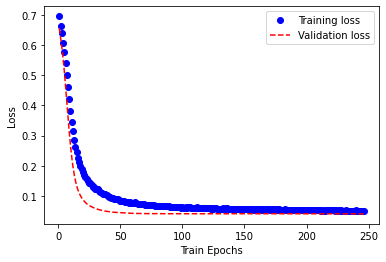

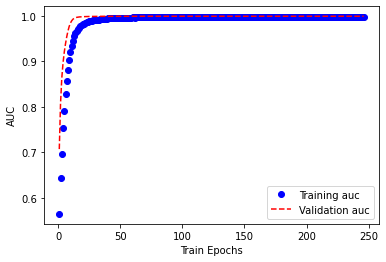

In [6]:
# inspect metrics
history_dict = history.history
loss = history_dict["loss"]
val_loss = history_dict["val_loss"]
auc = history_dict["auc"]
val_auc = history_dict["val_auc"]
epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "r--", label="Validation loss")
plt.xlabel("Train Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(epochs, auc, "bo", label="Training auc")
plt.plot(epochs, val_auc, "r--", label="Validation auc")
plt.xlabel("Train Epochs")
plt.ylabel("AUC")
plt.legend()
plt.show()

In [7]:
n = 5
s = 100

p = model.predict(x_val[:1000,:])[:, 0]

scores = eg.get_scores(x_val[:1000,:])
ix_srt = np.argsort(scores)

probs = eg.get_probabilities(x_val[:1000,:])[1]

p = np.convolve(p[ix_srt[::-1]], np.ones(n)/n, mode='valid')
scores = np.convolve(scores[ix_srt[::-1]], np.ones(n)/n, mode='valid')
probs = np.convolve(probs[ix_srt[::-1]], np.ones(n)/n, mode='valid')

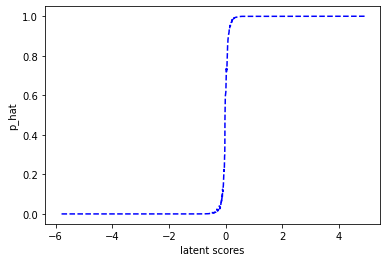

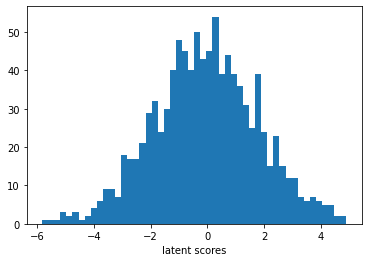

In [8]:
plt.plot(scores, p, '--b')
plt.xlabel('latent scores')
plt.ylabel('p_hat')
plt.show()

plt.hist(scores, bins=50)
plt.xlabel('latent scores')
plt.show()

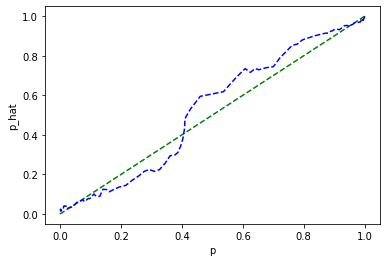

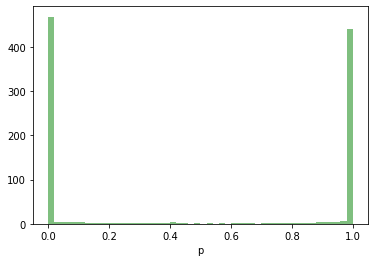

In [9]:
plt.plot(probs, probs, '--g')
plt.plot(probs, p, '--b')
plt.xlabel('p')
plt.ylabel('p_hat')
plt.show()

plt.hist(probs, bins=50, color='g', alpha=0.5)
plt.xlabel('p')
plt.show()

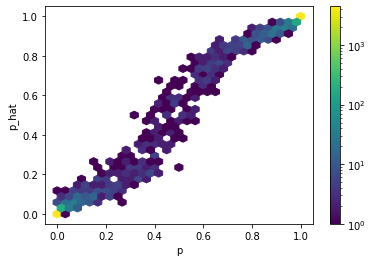

In [10]:
n = 1
s = 100

p = model.predict(x_val[:10000,:])[:, 0]

scores = eg.get_scores(x_val[:10000,:])

probs = eg.get_probabilities(x_val[:10000,:])[1]

plt.hexbin(probs, p, gridsize=30, bins='log')
plt.colorbar()
plt.xlabel('p')
plt.ylabel('p_hat')
plt.show()

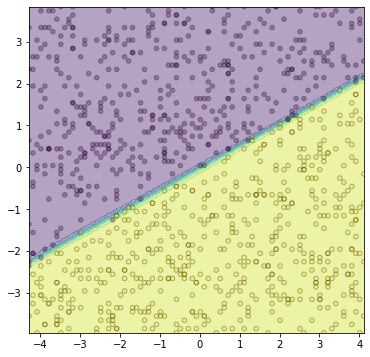

In [11]:
# Plot decision regions
I, J = 2, 6
x_min, x_max = x_val[:, I].min(), x_val[:, I].max()
y_min, y_max = x_val[:, J].min(), x_val[:, J].max()
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
xxyy = np.c_[xx.ravel(), yy.ravel()]
x_ = np.zeros((xxyy.shape[0], 10))
x_[:, I] = xxyy[:, 0]
x_[:, J] = xxyy[:, 1]
z = model.predict(x_)
z = z.reshape(xx.shape)
y_ = eg.get_labels(x_)

fig = plt.figure(figsize=(6,6))
ax = fig.gca()
ax.contourf(xx, yy, z, alpha=0.4)
ixs = np.random.randint(0, y_.shape[0]-1, 1000)
ax.scatter(x_[ixs, I], x_[ixs, J], c=y_[ixs], s=20, alpha=0.3, edgecolor="k")
plt.show()

#model.summary()

In [12]:
model.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_96 (Dense)            (None, 30)                330       
                                                                 
 dropout_72 (Dropout)        (None, 30)                0         
                                                                 
 dense_97 (Dense)            (None, 30)                930       
                                                                 
 dropout_73 (Dropout)        (None, 30)                0         
                                                                 
 dense_98 (Dense)            (None, 30)                930       
                                                                 
 dropout_74 (Dropout)        (None, 30)                0         
                                                                 
 dense_99 (Dense)            (None, 1)               

In [13]:
champion_params

{'learning_rate': 0.006,
 'batch': 256,
 'epoch': 177,
 'optimizer': 'sgd',
 'best_loss': {'loss': 0.03985120356082916, 'epoch': 246},
 'best_auc': {'auc': 0.9991049766540527, 'epoch': 142},
 'best_accuracy': {'accuracy': 0.9832000136375427, 'epoch': 52},
 'model': <keras.engine.sequential.Sequential at 0x7fabccf2ba90>}

In [14]:
scan_results

[{'learning_rate': 2.4e-05,
  'batch': 256,
  'epoch': 84,
  'optimizer': 'nadam',
  'best_loss': {'loss': 0.058525171130895615, 'epoch': 119},
  'best_auc': {'auc': 0.9985781311988831, 'epoch': 119},
  'best_accuracy': {'accuracy': 0.979449987411499, 'epoch': 117}},
 {'learning_rate': 3e-05,
  'batch': 256,
  'epoch': 84,
  'optimizer': 'nadam',
  'best_loss': {'loss': 0.045115336775779724, 'epoch': 119},
  'best_auc': {'auc': 0.9990540742874146, 'epoch': 119},
  'best_accuracy': {'accuracy': 0.9829999804496765, 'epoch': 119}},
 {'learning_rate': 3.6e-05,
  'batch': 256,
  'epoch': 84,
  'optimizer': 'nadam',
  'best_loss': {'loss': 0.04255693778395653, 'epoch': 119},
  'best_auc': {'auc': 0.9990641474723816, 'epoch': 119},
  'best_accuracy': {'accuracy': 0.9822999835014343, 'epoch': 119}},
 {'learning_rate': 0.004,
  'batch': 256,
  'epoch': 177,
  'optimizer': 'sgd',
  'best_loss': {'loss': 0.04038258269429207, 'epoch': 247},
  'best_auc': {'auc': 0.9991130232810974, 'epoch': 188},


### Tuning notes: 

Data: train 100096 / val 20000

--
* model: 30, 0.25, 30, 0.25, 30, 0.25, 30, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 80/80 **val_loss: 0.4221** - val_accuracy: 0.7657 - val_auc: 0.9857

--
* model: 30, 0.25, 30, 0.25, 30, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 60/80 **val_loss: 0.3241** - val_accuracy: 0.8463 - val_auc: 0.9856

--
* model: 40, 0.25, 40, 0.25, 40, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 40/80 **val_loss: 0.2726** - val_accuracy: 0.8848 - val_auc: 0.9889

--
* model: 50, 0.25, 50, 0.25, 50, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 38/80 **val_loss: 0.2555** - val_accuracy: 0.8832 - val_auc: 0.9916

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 28/80 **val_loss: 0.2552** - val_accuracy: 0.8909 - val_auc: 0.9929

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 1/ batch: 256 / Nadam lr: 2e-5
* Epoch: 48/80 **0.2557** - val_accuracy: 0.8771 - val_auc: 0.9935

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 20, 0.25, 6, 0.25, 1/ batch: 256 / Nadam lr: 2e-5
* Epoch: 47/80 **0.3482** - val_accuracy: 0.8346 - val_auc: 0.9910

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 1/ batch: 256 / SGD lr: 5e-3
* Epoch: 59/80 **0.2176** - val_accuracy: 0.8953 - val_auc: 0.9961

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 1/ batch: 256 / SGD lr: 3e-3
* Epoch: 80/100 **0.2205** - val_accuracy: 0.8970 - val_auc: 0.9951

--
8/1e-2=> 0.2021 - val_accuracy: 0.9207 - val_auc: 0.9904
8/8e-3=> 0.26...
8/1.3e-2=> 0.25